In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%config InlineBackend.figure_format = 'svg'

In [4]:
df = pd.read_parquet('data/dataset.parquet')
pangolin_lineages = df['pangolin_lineage']

In [23]:
# unique_chars = set(''.join(df['sequence'].astype(str).values))
unique_char_counts = Counter(''.join(df['sequence'].astype(str).values))
# print(unique_chars)
unique_char_counts

Counter({'T': 3501307,
         'A': 3247677,
         'G': 2134257,
         'C': 1993643,
         'N': 16279,
         'Y': 349,
         'R': 173,
         'K': 67,
         'S': 38,
         'W': 29,
         'M': 18})

In [25]:
df.head()

,strain,pangolin_lineage,date,date_submitted,sequence
0,hCoV-19/Benin/BJ-00332/2022,BA.1.1.1,2022-01-05,2022-08-05,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
1,hCoV-19/Benin/BJ-00171/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
2,hCoV-19/Benin/BJ-00177/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
3,hCoV-19/Benin/BJ-00047/2021,BA.1.15,2021-12-16,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
4,hCoV-19/Benin/BJ-00381/2021,BA.1.1,2021-12-31,2022-08-05,ACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA...


In [26]:
def extract_taxonomy(lineages, root="root"):
    hierarchy = {root : set()}
    for lineage in lineages:
        levels = lineage.split(".")
        hierarchy[root].add(levels[0])
        key = levels[0]
        for level in levels[1:]:
            if key not in hierarchy:
                hierarchy[key] = set()

            value = key + "." + level
            hierarchy[key].add(value)
            key = value

    return hierarchy

def extract_level_nodes(hierarchy):
    level_nodes = {}
    for _, children in hierarchy.items():
        for child in children:
            level = child.count(".") + 1
            if level not in level_nodes:
                level_nodes[level] = set()
            level_nodes[level].add(child)

    return level_nodes

def is_child_of(child, parent):
    child_path = child.split(".")
    parent_path = parent.split(".")
    return all(x == y for x, y in zip(child_path, parent_path)) and child != parent

def is_parent_of(parent, child):
    return is_child_of(child, parent)

def get_sibling_nodes(node, hierarchy):
    parent = get_parent(node)
    return hierarchy[parent] - {node}

def get_parent(node):
    parent = ".".join(node.split(".")[:-1])
    if parent == "":
        return "root"
    return parent

def is_terminal_node(node, hierarchy):
    parent = get_parent(node)
    if parent in hierarchy:
        if node not in hierarchy[parent]:
            raise ValueError(f"Node {node} not found in hierarchy")
        
        if node not in hierarchy:
            return True
        
        return False
    raise ValueError(f"Node {node} not found in hierarchy")

In [32]:
taxonomy = extract_taxonomy(pangolin_lineages)
levels = extract_level_nodes(taxonomy)

In [33]:
taxonomy

{'root': {'A', 'AY', 'B', 'BA', 'L', 'Q', 'R'},
 'BA': {'BA.1', 'BA.2'},
 'BA.1': {'BA.1.1', 'BA.1.14', 'BA.1.15'},
 'BA.1.1': {'BA.1.1.1'},
 'AY': {'AY.109',
  'AY.121',
  'AY.122',
  'AY.126',
  'AY.127',
  'AY.34',
  'AY.36',
  'AY.37',
  'AY.39',
  'AY.4',
  'AY.44',
  'AY.45',
  'AY.6'},
 'B': {'B.1'},
 'B.1': {'B.1.1', 'B.1.351', 'B.1.356', 'B.1.525', 'B.1.617'},
 'B.1.617': {'B.1.617.2'},
 'A': {'A.27'},
 'L': {'L.3'},
 'B.1.1': {'B.1.1.1', 'B.1.1.318', 'B.1.1.7'},
 'R': {'R.1'},
 'Q': {'Q.4'}}

In [34]:
from ete3 import Tree, TreeStyle, TextFace, CircleFace, NodeStyle

# Define the taxonomy as a Newick string
newick_str = "(root,(A,AY,(AY.109,AY.121,AY.122,AY.126,AY.127,AY.34,AY.36,AY.37,AY.39,AY.4,AY.44,AY.45,AY.6),(B,(B.1,(B.1.1,(B.1.1.1,B.1.1.318,B.1.1.7),B.1.351,B.1.356,B.1.525,B.1.617,(B.1.617.2)))),BA,(BA.1,(BA.1.1,(BA.1.1.1),BA.1.14,BA.1.15),BA.2),L,(L.3),Q,(Q.4),R,(R.1)),(A.27));"

# Create a Tree object from the Newick string
tree = Tree(newick_str)

# Define a custom tree style
tree_style = TreeStyle()
tree_style.mode = "r"  # Rectangular layout
tree_style.show_leaf_name = True  # Show leaf node names
tree_style.show_branch_length = False  # Hide branch lengths
tree_style.show_branch_support = False  # Hide branch support values

# Create a custom node style for leaf nodes
leaf_style = NodeStyle()
leaf_style["size"] = 10  # Adjust leaf node size
leaf_style["fgcolor"] = "black"  # Set leaf node color

# Create a custom node style for internal nodes
internal_style = NodeStyle()
internal_style["shape"] = "circle"  # Set internal node shape to circle
internal_style["fgcolor"] = "black"  # Set internal node color
internal_style["size"] = 10  # Adjust internal node size

# Apply the custom styles to the tree
tree.set_style(internal_style)
for leaf in tree.get_leaves():
    leaf.set_style(leaf_style)

# Render the tree
tree.render("phylogenetic_tree.png", tree_style=tree_style);

In [35]:
def sample_local_per_parent_node_dataset(hierarchy, parent_node, dataset):
    assert parent_node in hierarchy, f"Node {parent_node} not found in hierarchy"
    local_dataset = dataset[dataset['pangolin_lineage'].apply(lambda x: is_child_of(x, parent_node))]
    return local_dataset

def sample_local_per_node_dataset(hierarchy, node, dataset):
    siblings = get_sibling_nodes(node, hierarchy)
    positive_dataset = dataset[dataset['pangolin_lineage'].apply(lambda x: is_child_of(x, node))]
    negative_dataset = dataset[dataset['pangolin_lineage'].apply(lambda x: any(is_child_of(x, sibling) for sibling in siblings))]
    return positive_dataset, negative_dataset

def sample_local_per_level_dataset(level, hierarchy):
    pass

In [36]:
sampled_df = sample_local_per_parent_node_dataset(taxonomy, "A", df)

In [37]:
sampled_df

,strain,pangolin_lineage,date,date_submitted,sequence
31,hCoV-19/Benin/249839/2021,A.27,2021-01-31,2021-07-14,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
78,hCoV-19/Benin/250793/2021,A.27,2021-02-01,2021-09-28,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...


In [38]:
sampled_df.index.values

array([31, 78])

In [39]:
pos, neg = sample_local_per_node_dataset(taxonomy, "A", df)

In [40]:
pos

,strain,pangolin_lineage,date,date_submitted,sequence
31,hCoV-19/Benin/249839/2021,A.27,2021-01-31,2021-07-14,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
78,hCoV-19/Benin/250793/2021,A.27,2021-02-01,2021-09-28,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...


In [41]:
neg

,strain,pangolin_lineage,date,date_submitted,sequence
0,hCoV-19/Benin/BJ-00332/2022,BA.1.1.1,2022-01-05,2022-08-05,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
1,hCoV-19/Benin/BJ-00171/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
2,hCoV-19/Benin/BJ-00177/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
3,hCoV-19/Benin/BJ-00047/2021,BA.1.15,2021-12-16,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
4,hCoV-19/Benin/BJ-00381/2021,BA.1.1,2021-12-31,2022-08-05,ACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA...
...,...,...,...,...,...
363,hCoV-19/Chad/TCH-42/2021,AY.127,2021-11-04,2022-01-29,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
364,hCoV-19/Chad/TCH-44/2021,AY.36,2021-11-06,2022-01-29,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...
365,hCoV-19/Chad/TCH-47/2021,B.1.617.2,2021-11-08,2022-01-29,AGATCTGTTCTCTAAACGAACTTTAAAATCTGGGTGGCTGTCACTC...
366,hCoV-19/Chad/TCH-48/2021,AY.121,2021-11-08,2022-01-29,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...


In [42]:
def sample_local_per_parent_node_dataset2(hierarchy, parent_node, labels:np.array):
    assert parent_node in hierarchy, f"Node {parent_node} not found in hierarchy"
    local_dataset_indexes = np.argwhere([is_child_of(x, parent_node) for x in labels])
    return local_dataset_indexes.squeeze()

sample_local_per_parent_node_dataset2(taxonomy, "A", df["pangolin_lineage"].values)

array([31, 78])

,strain,pangolin_lineage,date,date_submitted,sequence
0,hCoV-19/Benin/BJ-00332/2022,BA.1.1.1,2022-01-05,2022-08-05,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...
1,hCoV-19/Benin/BJ-00171/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
2,hCoV-19/Benin/BJ-00177/2021,BA.1.1,2021-12-18,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
3,hCoV-19/Benin/BJ-00047/2021,BA.1.15,2021-12-16,2022-08-05,AGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCT...
4,hCoV-19/Benin/BJ-00381/2021,BA.1.1,2021-12-31,2022-08-05,ACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA...


# Feature extraction

In [5]:
from feature_extraction import ConventionalFeatures, MurugaiahFeatures, ZhangFeatures, CoutinhoFeatures

## Conventional Features

In [6]:
seq = df.iloc[0]['sequence']
print(len(seq))

29840


In [10]:
binary_features = ConventionalFeatures().extract_binary_features_single(seq, fourier=False)
print(binary_features.shape)

(29840, 4)


In [11]:
binary_features

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [11]:
kmer_features = ConventionalFeatures().extract_kmers_features_single(seq, k=2, normalize=False)
print(kmer_features.shape)

(16,)


In [12]:
kmer_features_all = ConventionalFeatures().extract_kmers_features(df['sequence'], k=2, normalize=False)
print(kmer_features_all.shape)

KeyError: 'CY'

In [13]:
kmer_img = CoutinhoFeatures().extract_single(seq)
print(kmer_img.shape)

(128, 128)


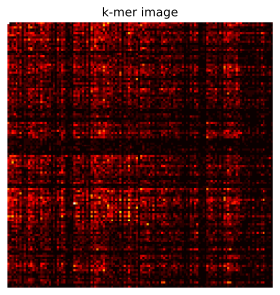

In [24]:
plt.imshow(kmer_img, cmap='hot', interpolation='nearest')
plt.axis('off');
plt.title('k-mer image')
plt.savefig('kmer_img.png', format='png', bbox_inches='tight', dpi=300)

In [14]:
fcgr_features = ConventionalFeatures().extract_fcgr_features_single(seq, resolution=128, fourier=False)
print(fcgr_features.shape)

(128, 128)


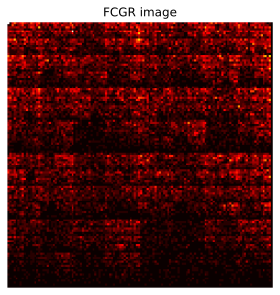

In [25]:
plt.imshow(fcgr_features, cmap='hot', interpolation='nearest')
plt.axis('off');
plt.title('FCGR image')
plt.savefig('fcgr_img.png', format='png', bbox_inches='tight', dpi=300)

In [22]:
fcgr_features_all = ConventionalFeatures().extract_fcgr_features(df['sequence'], resolution=8, fourier=False)
print(fcgr_features_all.shape)

(368, 8, 8)


## Murugaiah et al Features

In [23]:
murugaiah_features = MurugaiahFeatures().extract_single(seq, f=False)
print(murugaiah_features.shape)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/masterbee/anaconda3/envs/dl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/w9/b9mdbdzs39lby1wt6v087t6w0000gn/T/ipykernel_48678/3258689554.py", line 1, in <module>
    murugaiah_features = MurugaiahFeatures().extract_single(seq, fourier=False)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/masterbee/Desktop/AIMS-PROJECT/AI-viral-lineage-classification/src_aurel/feature_extraction/murugaiah_et_al.py", line 25, in extract_single
    f3_features = self._feature_based_on_arrangement_of_patterns(sequence) # 6 features
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/masterbee/Desktop/AIMS-PROJECT/AI-viral-lineage-classification/src_aurel/feature_extraction/murugaiah_et_al.py", line -1, in _feature_based_on_arrangement_of_patterns
KeyboardInte

In [ ]:
murugaiah_features_all = MurugaiahFeatures().extract(df['sequence'], fourier=False)
print(murugaiah_features_all.shape)

(120,)


## Zhang et al Features

In [20]:
def visualize_3d(features, title='3D Plot'):
    x = features[:, 0]
    y = features[:, 1]
    z = features[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z, label='Parametric curve')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    # plt.axis('off');
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    


(29840, 3)


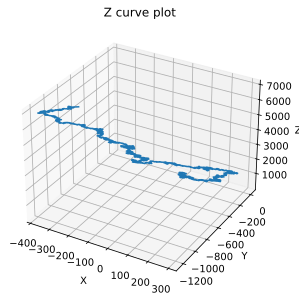

In [26]:
zhang_features = ZhangFeatures().extract_single(seq)
visualize_3d(zhang_features, title='Z curve plot')
plt.savefig('zcurve_img.png', format='png', bbox_inches='tight', dpi=300)
print(zhang_features.shape)

In [26]:
zhang_features_smoothed = ZhangFeatures().extract_single(seq, s=True)
print(zhang_features_smoothed.shape)

(29840, 3)


In [27]:
zhang_features_all = ZhangFeatures().extract(df['sequence'], smooth=False)
print(zhang_features_smoothed.shape)

(29840, 3)


/Users/masterbee/Desktop/AIMS-PROJECT/AI-viral-lineage-classification/src_aurel/feature_extraction/zhang_et_al.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features)


In [56]:
seq1 = seq[0:70]
seq2 = seq[200:250]


In [57]:
seq1

'AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCA'

In [39]:
kmer_img = CoutinhoFeatures(k=3).extract_single(seq1,)

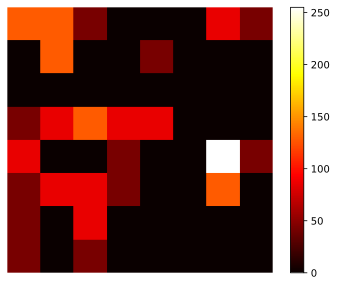

In [54]:
plt.imshow(kmer_img, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.savefig('eg_kmer_img.pdf', format='pdf')

In [48]:
fcgr_features = ConventionalFeatures().extract_fcgr_features_single(seq1, resolution=8, fourier=False)

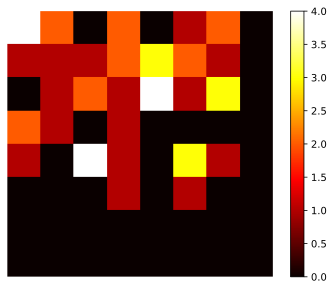

In [51]:
plt.imshow(fcgr_features, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.savefig('eg_cgr.pdf', format='pdf')